In [1]:
### Run this cell before continuing. 
library(tidyverse)
library(tidymodels)
library(repr)
library(readxl)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
#load data set
#student_data <- read_delim("data/student-por.csv", delim = ';')
#student_math=read.table("data/student-mat.csv",sep=";",header=TRUE)

# read, clean and wrangle data
student_port <- read.table("data/student-por.csv",sep=";",header=TRUE)
student_select <- student_port %>%
                select("sex", "address", "Medu", "Fedu", "failures", "famsup", "higher", "G1", "G2", "G3") %>%
                mutate(higher = as_factor(higher))

# obtain training set
student_split <- initial_split(student_select, prop = 0.75, strata = higher) 
student_train <- training(student_split)
student_train

# higher is our target variable
counts <- student_train %>%
        group_by(higher) %>%
        summarize(n=n()) 
        
counts

ave_grade <- student_train %>%
            summarize(G1 = mean(G1), G2 = mean(G2), G3 = mean(G3))
ave_grade


,sex,address,Medu,Fedu,failures,famsup,higher,G1,G2,G3
,<chr>,<chr>,<int>,<int>,<int>,<chr>,<fct>,<int>,<int>,<int>
2,F,U,1,1,0,yes,yes,9,11,11
3,F,U,1,1,0,no,yes,12,13,12
4,F,U,4,2,0,yes,yes,14,14,14
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
646,F,U,3,1,0,yes,yes,15,15,16
647,F,U,1,1,0,no,yes,11,12,9
649,M,R,3,2,0,no,yes,10,11,11


`summarise()` ungrouping output (override with `.groups` argument)



higher,n
<fct>,<int>
yes,435
no,52


G1,G2,G3
<dbl>,<dbl>,<dbl>
11.45175,11.55441,11.82136


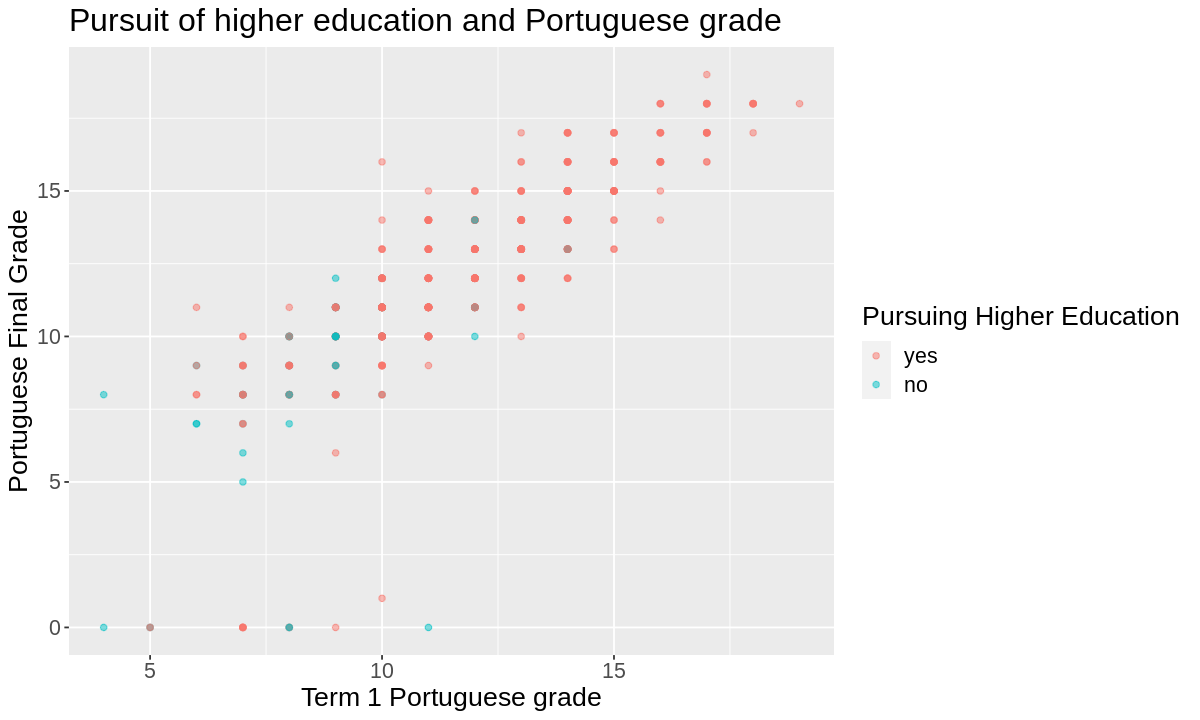

In [3]:
options(repr.plot.width=10, repr.plot.height=6)

student_por_plot <- student_train %>%
                select(G1, G3, higher) %>%
                ggplot(aes(x = G1, y = G3, colour = higher)) + 
                geom_point(alpha = 0.5)+
                labs(x = "Term 1 Portuguese grade", y = "Portuguese Final Grade", colour = "Pursuing Higher Education", title = "Pursuit of higher education and Portuguese grade")+
                theme(text = element_text(size=16))      
student_por_plot


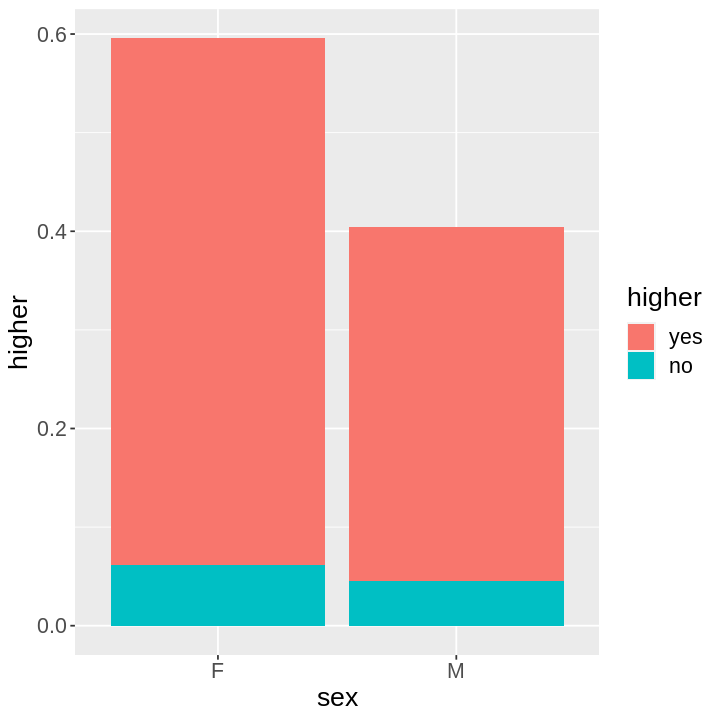

In [4]:
options(repr.plot.width=6, repr.plot.height=6)
student_gender <- student_train %>%
                select(sex, higher) %>%
                ggplot(aes(x=sex, y=higher))+
                geom_bar(aes(y = ..count../sum(..count..), fill = higher))+
                theme(text = element_text(size=16))
student_gender

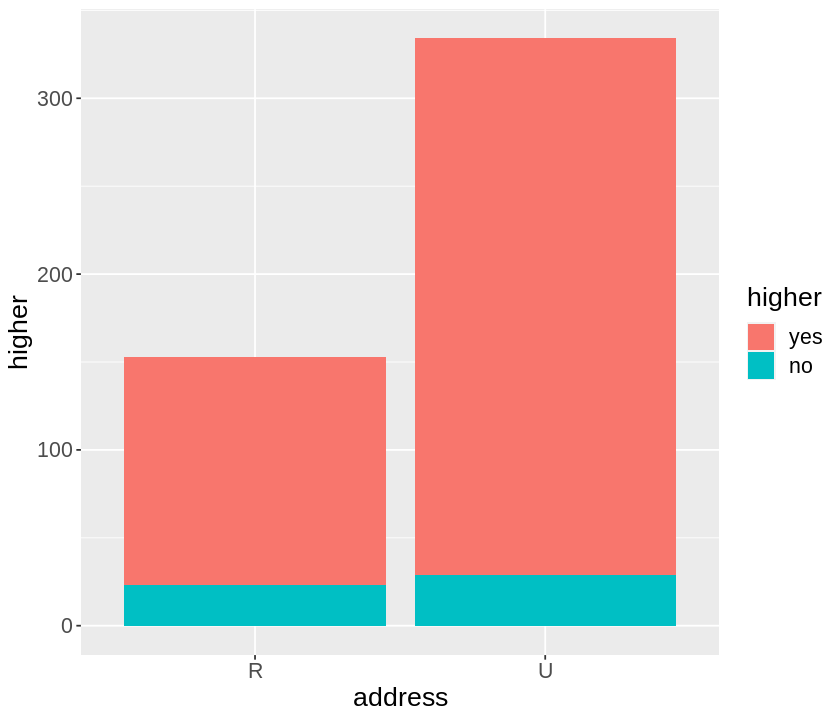

In [5]:
options(repr.plot.width=7, repr.plot.height=6)
student_address <- student_train %>%
                select(address, higher) %>%
                ggplot(aes(x=address, y=higher))+
                geom_bar(aes(y = ..count.., fill = higher))+
                theme(text = element_text(size=16))
student_address



`summarise()` regrouping output by 'address' (override with `.groups` argument)



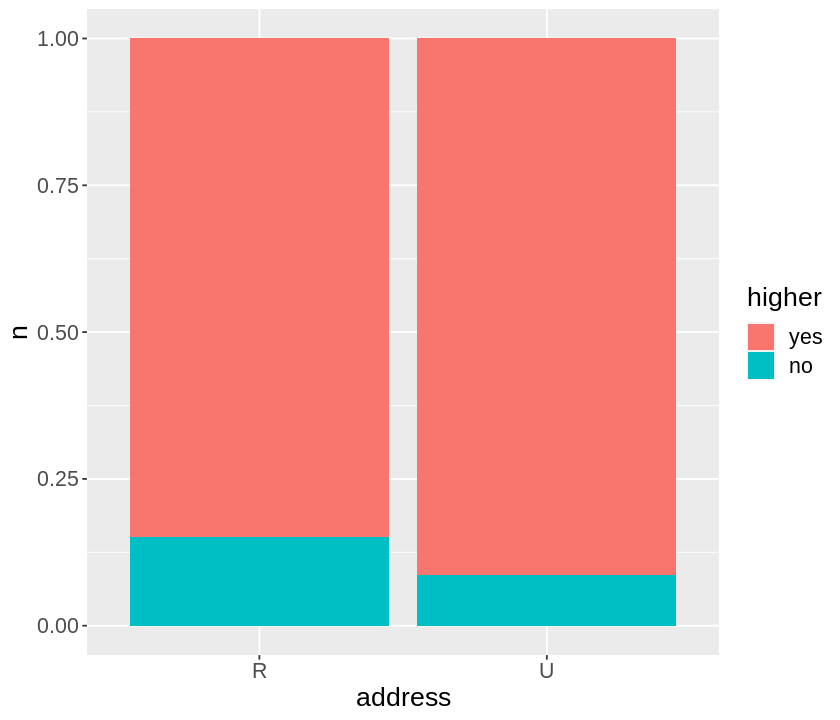

In [6]:
address_n_higher <- student_train %>%
            select(address, higher)%>%
            group_by(address, higher)%>%
            summarize(n = n())
address_plot <- ggplot(address_n_higher, aes(x = address, y = n, fill = higher)) +
                    geom_bar(stat = "identity", position = "fill")+
                theme(text = element_text(size=16))
address_plot

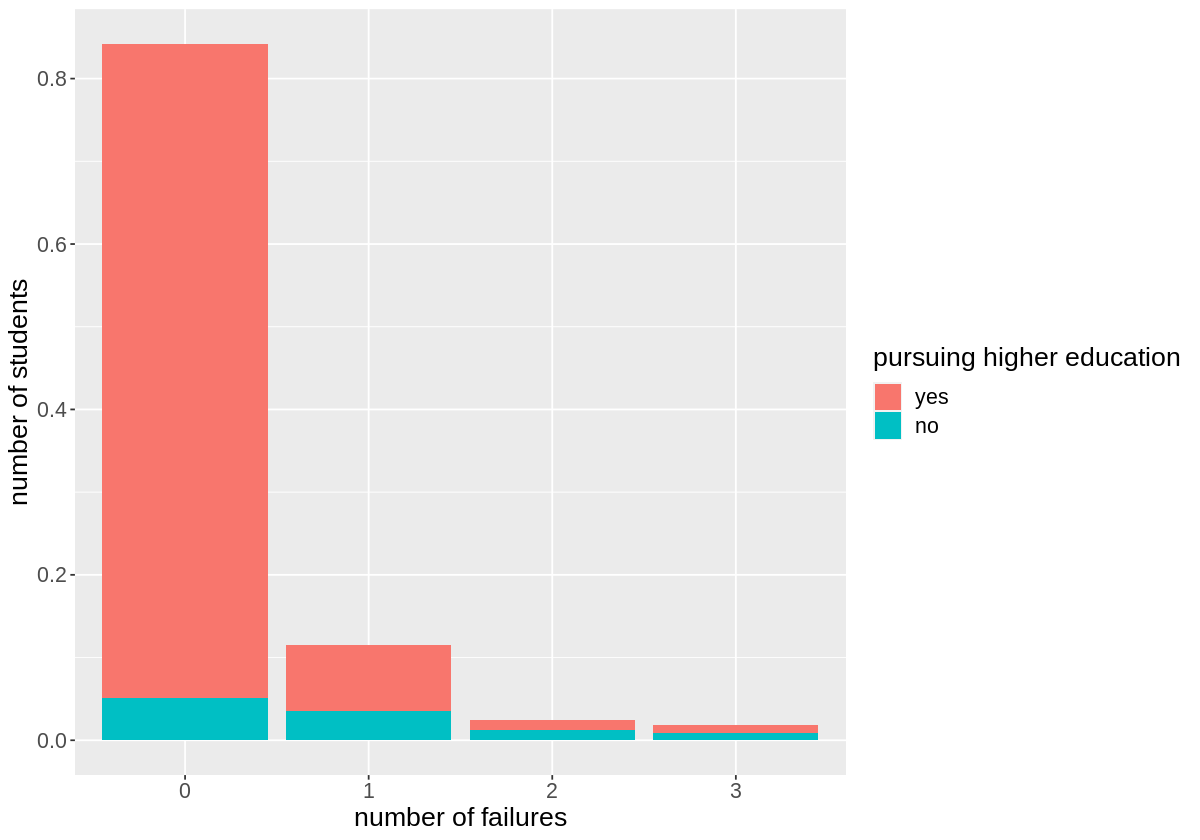

In [7]:
options(repr.plot.width=10, repr.plot.height=7)
student_failures <- student_train %>%
                select(failures, higher) %>%
                ggplot(aes(x=as.factor(failures), y=higher))+
                geom_bar(aes(y = ..count../sum(..count..), fill = higher))+
                labs(y = "number of students", x = "number of failures", fill = "pursuing higher education")+
                theme(text = element_text(size=16))
student_failures

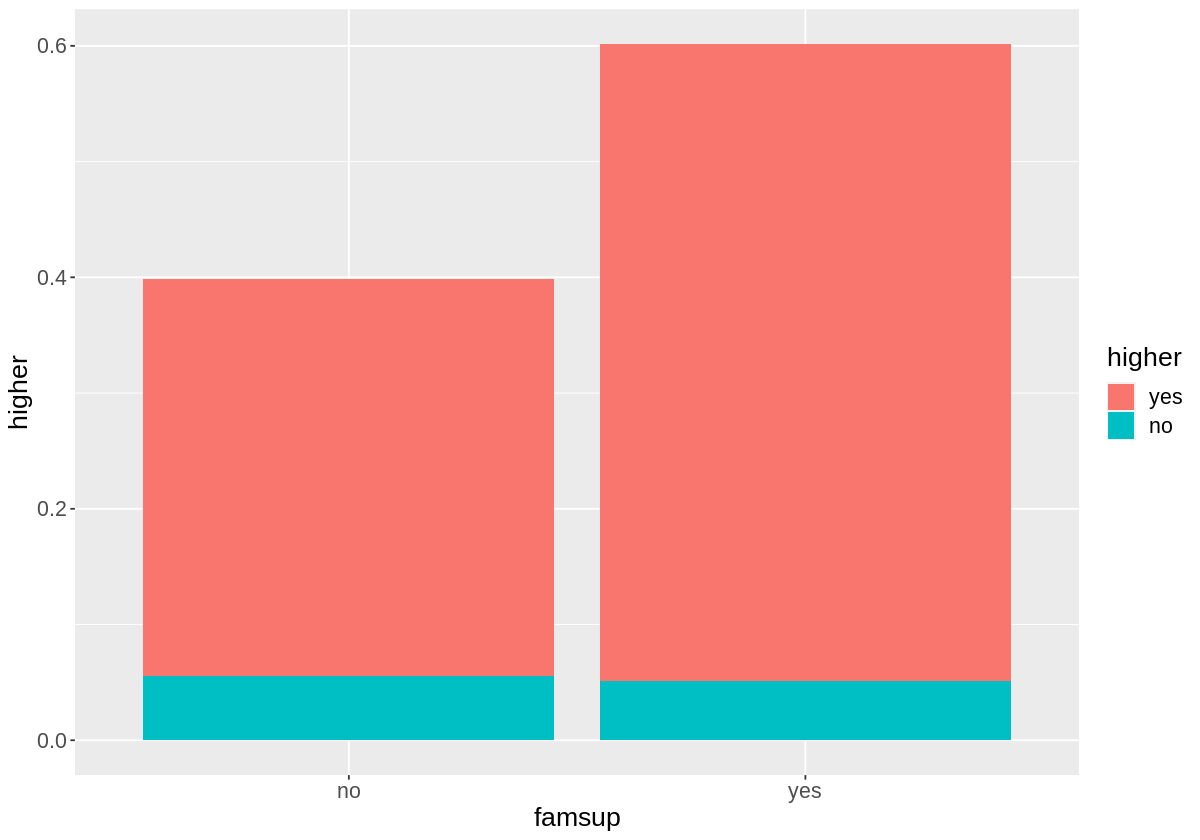

In [8]:
family_support <- student_train %>%
                select(famsup, higher) %>%
                ggplot(aes(x=famsup, y=higher))+
                geom_bar(aes(y = ..count../sum(..count..), fill = higher))+
                theme(text = element_text(size=16))
family_support